In [1]:
# Load libraries

import numpy as np
import pandas as pd
import math
import random
import GPy
import seaborn as sns
import matplotlib.pyplot as plt
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Hide some warnings
pd.options.mode.chained_assignment = None 

### Load data

In [32]:
# Load four sheets from excel file

denver = pd.read_excel('Datas.xls', sheet_name='DEN')
newyork = pd.read_excel('Datas.xls', sheet_name='NYC')
sanfrancisco = pd.read_excel('Datas.xls', sheet_name='SFC')
texas = pd.read_excel('Datas.xls', sheet_name='TXS')

# Set random seed
random.seed(48)

In [33]:
# Cleen data to make it easier to handle

denver['station'] = denver['station'].replace(np.nan,'DENVER INTL AP')
denver['station'] = denver['station'].replace('DENVER INTL AP', 'DEN')
newyork['station'] = newyork['station'].replace(np.nan, 'JFK')
sfc = sanfrancisco.drop(columns = 'valid', axis=1)

In [34]:
#Function to rename columns 

def rename_columns(df, col_names):
    cols = df.columns
    for col, new_col in zip(cols, col_names):
        df.rename(columns={col:new_col}, inplace=True)

In [35]:
# Rename columns in all datasets to same column names

col_names = ['station', 'skycloud', 'day', 'tmpf', 'feel', 
             'zenith', 'azimuth', 'glob', 'direct', 
             'diffused', 'albedo', 'time', 'power']

rename_columns(denver, col_names)
rename_columns(newyork, col_names)
rename_columns(sfc, col_names)
rename_columns(texas, col_names)

In [36]:
# Join all 4 datasets into a single dataframe

frames = [denver, newyork, sfc, texas]
data = pd.concat(frames)


# Create dataset for denver station
den = data.loc[data['station'] == 'DEN']

### Feature selection
For more detail on feature selection, see notebook 'GPR_article_recreation' 

In [38]:
# Drop columns with low correlation

den1 = den.drop(columns = ['skycloud', 'feel', 'albedo'], axis=1)

In [39]:
# Drop rows with azimuth = -99 values

den1.drop(den1.index[den1['azimuth'] == -99], inplace = True)

In [42]:
print(den1)

     station  day   tmpf  zenith  azimuth  glob  direct  diffused  time  power
8        DEN    1  41.00    87.2    123.1     3       0         3     8    7.6
9        DEN    1  42.98    79.9    131.7    29       0        29     9   12.9
10       DEN    1  46.94    72.2    143.5    93       0        93    10    4.7
11       DEN    1  48.92    66.5    156.9   315     407       153    11   10.3
12       DEN    1  51.98    63.3    171.7   485     732       157    12   18.1
...      ...  ...    ...     ...      ...   ...     ...       ...   ...    ...
8749     DEN  365  30.92    63.3    187.3    84       0        84    13   15.7
8750     DEN  365  26.96    66.3    202.1    73       0        73    14   12.0
8751     DEN  365  19.94    71.8    215.7   290     542       121    15    5.0
8752     DEN  365  17.06    79.4    227.5   178     726        45    16    0.0
8753     DEN  365  15.98    86.9    236.5    18     365         0    17    0.0

[4798 rows x 10 columns]


### Scaler and train test split

In [44]:
# Create X and y values

X_val = den1.drop(columns = ['station', 'day', 'time', 'power'], axis=1)
X = X_val.values
y = den1.power.values

In [21]:
print(X_val)

       tmpf   feel  zenith  azimuth  glob  direct  diffused  albedo
0     48.02  43.43    99.0    -99.0     0       0         0    0.22
1     48.02  42.39    99.0    -99.0     0       0         0    0.22
2     46.04  41.41    99.0    -99.0     0       0         0    0.22
3     44.96  40.08    99.0    -99.0     0       0         0    0.22
4     42.08  39.19    99.0    -99.0     0       0         0    0.22
...     ...    ...     ...      ...   ...     ...       ...     ...
8755  62.06  62.06    99.0    -99.0     0       0         0    0.19
8756  62.96  62.96    99.0    -99.0     0       0         0    0.19
8757  64.04  64.04    99.0    -99.0     0       0         0    0.19
8758  64.04  64.04    99.0    -99.0     0       0         0    0.19
8759  64.04  64.04    99.0    -99.0     0       0         0    0.19

[35040 rows x 8 columns]


In [76]:
# Train test split and scale data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48, shuffle=False)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

scaler = MinMaxScaler()
X_tr_sc = scaler.fit_transform(X_train)
X_te_sc = scaler.transform(X_test)
y_tr_sc = scaler.fit_transform(y_train)
y_te_sc = scaler.transform(y_test)

y_tr_sc = np.squeeze(y_tr_sc)

### Create NgBoost model

In [77]:
# Create NgBoost model, fit with training values, and predict test set

ngb = NGBRegressor()
ngb.fit(X_tr_sc, y_tr_sc)
Y_preds = ngb.predict(X_te_sc)
Y_dists = ngb.pred_dist(X_te_sc)

[iter 0] loss=0.2900 val_loss=0.0000 scale=1.0000 norm=0.4555
[iter 100] loss=-0.3239 val_loss=0.0000 scale=2.0000 norm=0.8609
[iter 200] loss=-0.7906 val_loss=0.0000 scale=2.0000 norm=0.9877
[iter 300] loss=-1.0917 val_loss=0.0000 scale=2.0000 norm=1.0711
[iter 400] loss=-1.2706 val_loss=0.0000 scale=2.0000 norm=1.0837


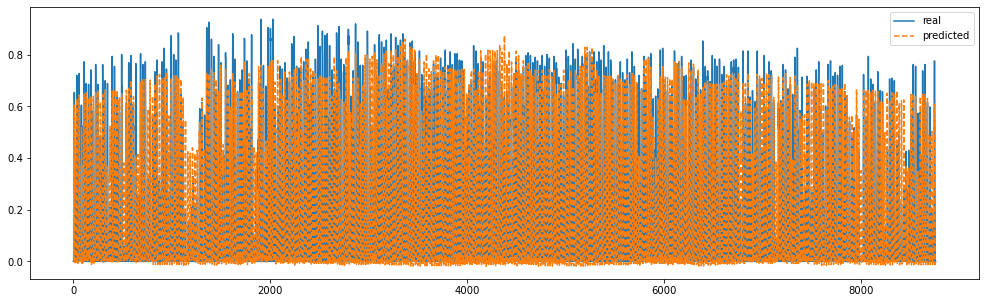

In [12]:
f, ax = plt.subplots(1, 1, figsize=(17, 5))

ax.plot(y_te_sc, label='real')
plt.plot(Y_preds, '--', label='predicted')
plt.legend()

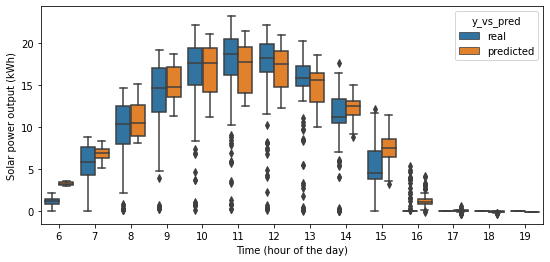

In [78]:
# Boxplot of distribution of predicted y values versus the actual values

d_new = den1[len(X_train):]
y_pred = Y_preds.reshape(-1, 1)
pred_actual = scaler.inverse_transform(y_pred)

lst1 = ['real'] * len(X_test)
lst2 = ['predicted'] * len(X_test)

test_df1 = d_new.copy()
test_df1['y_vs_pred'] = lst1

test_df2 = d_new.copy()
test_df2.drop('power', inplace=True, axis=1)

test_df2['y_vs_pred'] = lst2
test_df2['power'] = pred_actual

frames_ = [test_df1, test_df2]
test_df = pd.concat(frames_)

fig, ax = plt.subplots(1,1, figsize=(9, 4))
ax = sns.boxplot(x="time", y="power", hue="y_vs_pred", data=test_df)
ax.set_xlabel('Time (hour of the day)')
ax.set_ylabel('Solar power output (kWh)')

plt.show()

### RMSE and MAE scores

In [79]:
mae = mean_absolute_error(y_te_sc, Y_preds)
mse = mean_squared_error(y_te_sc, Y_preds)
rmse = math.sqrt(mse)

print('MAE (%): ', mae*100)
print('RMSE (%): ', rmse*100)

MAE (%):  9.462349498058563
RMSE (%):  15.50071591209107


In [50]:
y_test_actual = scaler.inverse_transform(y_te_sc)

mae2 = mean_absolute_error(y_test_actual, pred_actual)
mse2 = mean_squared_error(y_test_actual, pred_actual)
rmse2 = math.sqrt(mse2)

print('MAE (actual values): ', mae2)
print('RMSE: (actual values)', rmse2)

MAE (actual values):  2.4319237739357025
RMSE: (actual values) 3.983675148806909


### Plot real versus predicted values with the standard deviation

In [51]:
# Extract standard deviation and put data in correct format

params = Y_dists.params
stdev = params['scale']
stdev = stdev.reshape(-1, 1)

stdev_actual = scaler.inverse_transform(stdev)

std_ = stdev_actual.reshape((len(stdev), 1))
pred_act = pred_actual.reshape((len(stdev), 1))

std_ = np.concatenate(std_, axis=0 )
pred_actual = np.concatenate(pred_act, axis=0 )

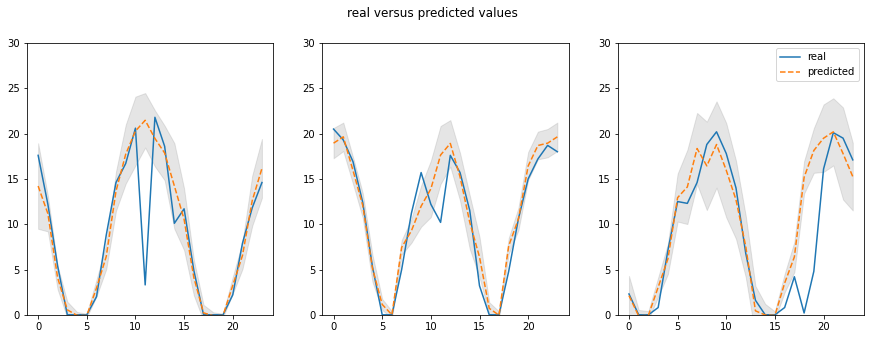

In [53]:
X_len = 24
x = np.arange(X_len) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('real versus predicted values')

ax1.set_ylim(0,30)
ax1.plot(x[:X_len], y_test_actual[0:24], label='real')
ax1.plot(x[:X_len], pred_actual[0:24], '--', label='predicted')
ax1.fill_between(x[:X_len], pred_actual[0:24] - std_[0:24], pred_actual[0:24] + std_[0:24],
                 color='gray', alpha=0.2)

ax2.set_ylim(0,30)
ax2.plot(x[:X_len], y_test_actual[720:744], label='real')
ax2.plot(x[:X_len], pred_actual[720:744], '--', label='predicted')
ax2.fill_between(x[:X_len], pred_actual[720:744] - std_[720:744], pred_actual[720:744] + std_[720:744],
                 color='gray', alpha=0.2)

ax3.set_ylim(0,30)
ax3.plot(x[:X_len], y_test_actual[200:224], label='real')
ax3.plot(x[:X_len], pred_actual[200:224], '--', label='predicted')
ax3.fill_between(x[:X_len], pred_actual[200:224] - std_[200:224], pred_actual[200:224] + std_[200:224],
                 color='gray', alpha=0.2)

plt.legend()
plt.show()
